In [ ]:
import numpy as np
from optiland import analysis, optic, optimization
from optiland.physical_apertures.rectangular import RectangularAperture
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
import optiland.backend as be

In [ ]:
lens = optic.Optic(name="carta")

lens.set_field_type("angle")
lens.add_field(y=0)

lens.set_aperture(aperture_type="EPD", value=80)

lens.add_wavelength(value=0.587, is_primary=True)
val = 30
bar=RectangularAperture(
    y_max=val,
    y_min=-val,
    x_max=val,
    x_min=-val,
)
#lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=0, z=np.inf, y=10, aperture=bar)
lens.add_surface(index=1, z=-100, aperture=bar)
lens.add_surface(index=2, z=100, radius_y=200,radius_x=np.inf, material="mirror", rx=np.radians(-10), surface_type="toroidal", coeffs_poly_y=[0.2,0.32,0.4,0.5], is_stop=True)

lens.surface_group.surfaces[2].geometry.coeffs_poly_y = [0,0,0,0]

print(lens.surface_group.surfaces[2].geometry.coeffs_poly_y)

carta_aperture = RectangularAperture(
    y_max=600,
    y_min=-600,
    x_max=50,
    x_min=-50,
)
lens.add_surface(index=3, z=-100, y=-650, aperture=carta_aperture)
#lens.surface_group.surfaces[1].aperture = aperture
#lens.surface_group.surfaces[2].aperture = carta_aperture

[0, 0, 0, 0]


In [ ]:
problem = optimization.OptimizationProblem()
problem.add_variable(
    lens,
    "tilt",
    axis="x",
    surface_number=2,
    min_val=np.radians(-50.0),
    max_val=np.radians(-1.0),
)

problem.add_variable(
    lens,
    "toroidal_R_yz",
    surface_number=2,
    min_val=0,
    max_val=400,
)
limits = [0.01, 0.00005, 0.000001]
for i in range(3):
    problem.add_variable(
        lens,
        "toroidal_coeff",
        surface_number=2,
        coeff_index=i,
        min_val=-limits[i],
        max_val=limits[i],
    )

for i in range(10):
    input_data = {
        "optic": lens,           # Your lens system
        "surface_number": -1,     # Use -1 for the image plane
        "Hx": 0.0,                # Normalized Field X
        "Hy": 60/80 -i*2/10 * 60/80,                # Normalized Field Y (e.g., full field)
        "Px": 0.0,                # Normalized Pupil X
        "Py": 1-i*2/10,                # Normalized Pupil Y (e.g., chief ray)
        "wavelength": 0.587       # Wavelength in microns
        }

    problem.add_operand(
        operand_type="real_y_intercept",
        target=-45-i*1200/10,
        weight=1.0,
        input_data=input_data
    )

#optimizer = optimization.OptimizerGeneric(problem)
#res = optimizer.optimize(maxiter=10000,tol=1e-9)
# Global optimizer
optimizer = optimization.DifferentialEvolution(problem)
res = optimizer.optimize(maxiter=10, workers=-1)

#optimizer = optimization.BasinHopping(problem)
def counter(x,f,accept):
    if not hasattr(counter, "count"):
        counter.count = 0
    counter.count += 1
    print("Iteration number:", counter.count)
#res = optimizer.optimize(niter=10, callback=counter)
problem.info()

[-1311.07744006]


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

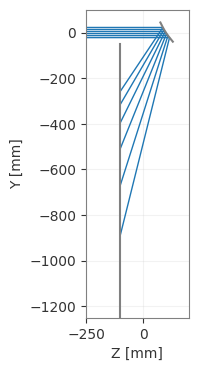

In [ ]:
ray = lens.trace_generic(Hx=0, Hy=-60/80, Px=0, Py=-1, wavelength=0.55)
print(ray.y)
lens.draw(num_rays=10, xlim=(-250,200), ylim=(-1250,100))

In [ ]:
print(lens.surface_group.surfaces[2].geometry.R_yz)
print(lens.surface_group.surfaces[2].geometry.c_yz)

215.85958408333784
0.004632641187772907


1
1280


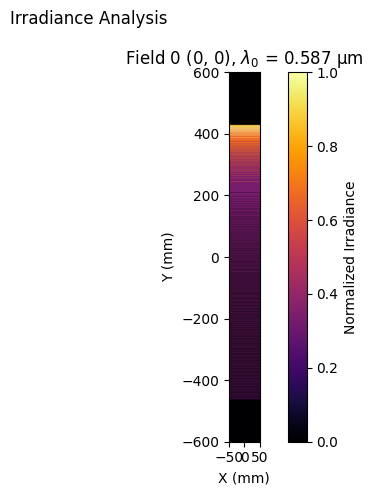

In [ ]:
irradiance = IncoherentIrradiance(
    lens,
    #num_rays=1000_000,  # 1 million rays
    num_rays=1000,
    detector_surface=-1,  # image surface
    distribution="uniform",
    res=[1,1280]
)
irradiance.view(normalize=True)
irr_data = irradiance.data
print(irradiance.npix_x)
print(irradiance.npix_y)